# Assignment 1

## 4. Exact Diagonalization study of the quantum Ising model

### 4.1 Dense ED

Generate the quantum Ising Hamiltonian (4) as a dense matrix and call an explicit diagonalization routine for the entire spectrum for system sizes $L = 8, 10, 12, 14,$ and for a range of values of h. Plot the ground state energy as a function of $h$ for the various $L$. Compare the open systems with periodic ones for the same parameters—how does each phase react to the boundaries?

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
directory = 'figures'
import os
if not os.path.exists(directory):
    os.makedirs(directory)
from multiprocessing import Pool
from functools import partial


In [2]:
def denseH(L,J, h, periodic):
    dim=2**L
    H=np.zeros((dim, dim))
    
    for beta in range(dim):
        for j in range(1,L+1):
            alpha = beta ^ (1<<j-1)
            H[alpha, beta]=-h

    for alpha in range(dim):
        for j in range(1, L): 
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j):
                H[alpha, alpha]-=J
            else:
                H[alpha, alpha]+=J
                
        if periodic:
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))) :
                H[alpha, alpha]-=J
            else:
                H[alpha, alpha]+=J
                
    return H
    

In [3]:
def sparseH(L, J, h, periodic):
    dim = 2 ** L
    H_data = []
    H_rows = []
    H_cols = []

    for beta in range(dim):
        for j in range(1, L + 1):
            alpha = beta ^ (1 << (j - 1))
    
            H_data.append(-h)
            H_rows.append(alpha)
            H_cols.append(beta)

    for alpha in range(dim):
        A = 0
        for j in range(1, L):
            if 2 * (alpha & (1 << (j - 1))) == alpha & (1 << j):
                A -= J
            else:
                A += J
                
        if periodic:
            if (alpha & (1 << (L - 1))) == ((alpha & (1 << 0)) * (2 ** (L - 1))):
                A -= J
            else:
                A += J
        
        if A != 0:
            H_data.append(A)
            H_rows.append(alpha)
            H_cols.append(alpha)

    H_data = np.array(H_data, dtype=float)

    return scipy.sparse.csr_matrix((H_data, (H_rows, H_cols)), shape=(dim, dim), dtype=np.float64)

In [23]:
L_values = [8,10,12,14]
ground_state_energies = {L: [] for L in L_values}

def calculate_h_values(L):
    
    if L==8:
        return 50
    if L==10:
        return 25
    if L==12:
        return 20
    if L==14:
        return 15
    else:
        return 20


for L in L_values:
    h_values = np.linspace(0, 2, calculate_h_values(L))
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        H = denseH(L, 1, h, True)
        ground_state = scipy.linalg.eigh(H, subset_by_index=(0, 0), eigvals_only=True)
        ground_state_energies[L].append(ground_state)

Calculating for L=14: 100%|███████████████████████████████████████████████████████████| 15/15 [28:12<00:00, 112.84s/it]


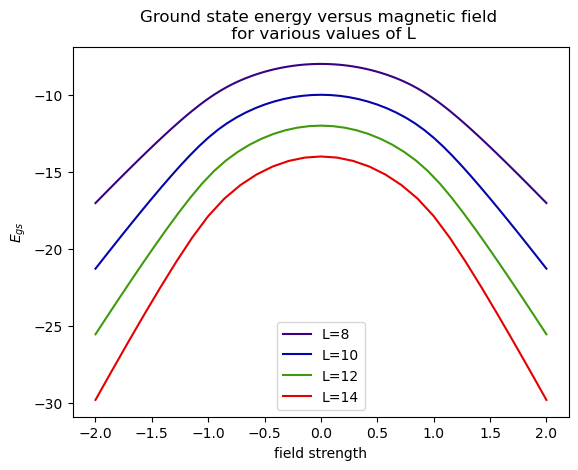

In [29]:
import matplotlib.pyplot as plt
import os

plt.style.use('default')

for i, (L, energies) in enumerate(ground_state_energies.items()):
    h_values = np.linspace(0, 2, calculate_h_values(L))
    mirrored_h_values = np.concatenate((-h_values[::-1], h_values))
    mirrored_energies = np.concatenate((energies[::-1], energies))
    plt.plot(mirrored_h_values, mirrored_energies, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('field strength')
plt.ylabel(r'$E_{gs}$')
plt.title('Ground state energy versus magnetic field \n for various values of L')
plt.legend()
plt.savefig(os.path.join(directory, 'plot-dense.png'), dpi=400)
plt.show()


In [32]:
L_values = [8,10,12,14]
h_values = np.linspace(0, 2, 20)
periodicgs = {L: [] for L in L_values}
opengs = {L: [] for L in L_values}


for L in L_values:
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        Hper = sparseH(L, 1, h, True)
        Hopen = sparseH(L, 1, h, False)
        ground_state = scipy.sparse.linalg.eigsh(Hper, k=1, which='SA', return_eigenvectors=False)[0]
        periodicgs[L].append(ground_state)
        ground_state = scipy.sparse.linalg.eigsh(Hopen, k=1, which='SA', return_eigenvectors=False)[0]
        opengs[L].append(ground_state)


Calculating for L=14: 100%|████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.10s/it]


In [ ]:
def Egs(L, J, h, periodic):
    H = sparseH(L, J, h, periodic)
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H)
    ground_state = min(eigenvalues.real)
    return ground_state

In [ ]:
paraground_states=[]
ferroground_states=[]
Ls=[2,3,4,5,6,7,8,9,10]

for L in Ls:
    ferroground_states.append(Egs(L, 0.3, True)/L)
    paraground_states.append(Egs(L, 1.7, True)/L)

plt.plot(Ls, ferroground_states)
plt.show()
plt.plot(Ls, paraground_states)
plt.show()

In [ ]:
paraground_states=[]
ferroground_states=[]
Ls=[2,3,4,5,6,7,8,9,10]

for L in Ls:
    ferroground_states.append(Egs(L, 0.3, False)/L)
    paraground_states.append(Egs(L, 1.7, False)/L)

plt.plot(Ls, ferroground_states)
plt.show()
plt.plot(Ls, paraground_states)
plt.show()

In [ ]:
H = sparseH(8, 1, 1, True)  # Call sparseH function to get the sparse matrix
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(H)

In [ ]:
print(Egs(15, 1, 1, True))

In [ ]:
def compute_ground_state_energy(L, h):
    H = sparseH(L, 1, h, True)
    eigenvalues, _ = scipy.sparse.linalg.eigsh(H, k=1, which='SA')
    return eigenvalues[0]

def compute_excitation_energies(L, h, num_excited_states):
    H = sparseH(L, 1, h, True)
    eigenvalues, _ = scipy.sparse.linalg.eigsh(H, k=num_excited_states + 1, which='SA')
    return eigenvalues[1:] - eigenvalues[0]

L = 20 # largest system size
h_values = np.linspace(-2, 2, 100)
num_excited_states = 10  # number of excited states to consider

# Initialize progress bar
progress_bar = tqdm(total=len(h_values), desc='Computing')

# Compute ground state energies and excitation energies for each value of h
ground_state_energies = []
excitation_energies = []

for h in h_values:
    ground_state_energy = compute_ground_state_energy(L, h)
    ground_state_energies.append(ground_state_energy)
    excitation_energy = compute_excitation_energies(L, h, num_excited_states)
    excitation_energies.append(excitation_energy)
    # Update progress bar
    progress_bar.update(1)

progress_bar.close()

# Plotting
plt.figure(figsize=(10, 6))
for i in range(num_excited_states):
    plt.plot(h_values, np.array(excitation_energies)[:, i], label=f'Excited state {i+1}')

plt.xlabel('h')
plt.ylabel('Excitation Energy')
plt.title('Excitation Energies vs. Magnetic Field')
plt.legend()
plt.grid(True)
plt.show()